In [1]:
from time import gmtime, strftime

import albumentations
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

# ---- My utils ----
import sys
sys.path.insert( 0, '..' ) # To be able to access to utils\n",
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

Working with Jupyter notebook! (Default Arguments)


usage: ipykernel_launcher.py [-h] [--verbose]
                             [--optimizer {adam,sgd,sgd_momentum,rmsprop}]
                             [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--min_learning_rate MIN_LEARNING_RATE]
                             [--plateau_scheduler] [--steps_best]
                             [--steps_scheduler] [--img_size IMG_SIZE]
                             [--crop_size CROP_SIZE] [--model_name MODEL_NAME]
                             [--pretrained]
                             [--validation_size VALIDATION_SIZE]
                             [--output_dir OUTPUT_DIR] [--data_augmentation]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1005/jupyter/kernel-4ee8063e-8108-4a80-aacf-6350ab17e897.json


In [2]:
if args.data_augmentation:
    train_aug = transforms.Compose([
        transforms.ToPILImage(), # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.RandomHorizontalFlip(0.5), # because this method is used for PIL Image dtype
        transforms.ToTensor(), # because inpus dtype is PIL Image
    ])
else:
    train_aug = transforms.Compose([
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ])

val_aug = transforms.Compose([
    transforms.ToPILImage(), # because the input dtype is numpy.ndarray
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(), # because inpus dtype is PIL Image
])

# data_partition='', data_augmentation=None, validation_size=0.15, seed=42
train_dataset = SIMEPU_Dataset(data_partition='train', transform=train_aug, validation_size=args.validation_size)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=val_aug, validation_size=args.validation_size)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)

In [3]:
# LABELS2TARGETS: Diccionario {"clase":target} para conocer el target que representa una clase dada
model = model_selector(args.model_name, num_classes=len(LABELS2TARGETS), pretrained=args.pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load("../results/resnet18_sgd_momentum_224to224_lr0.01_NoDA/model_best_accuracy.pt"))
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [4]:
criterion = nn.CrossEntropyLoss()
current_val_loss, current_val_accuracy = val_step(val_loader, model, criterion)

In [5]:
print("Val loss: {:.4f} / Val Accuracy: {:.2f}%".format(current_val_loss, current_val_accuracy))

Val loss: 0.1831 / Val Accuracy: 94.12%


In [6]:
class_correct = list(0. for i in range(len(LABELS2TARGETS)))
class_total = list(0. for i in range(len(LABELS2TARGETS)))
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).squeeze() # lista con los labels correctos (1) e incorrectos (0)
        # Recorro todos mis labels del batch actual
        for i in range(len(labels)):
            label = labels[i] # Extraigo el label en concreto del bucle
            class_correct[label] += correct[i].item() # Si el label ha sido clasificado bien sumaremos 1
            class_total[label] += 1 # Sumo 1 al contador del label actual
assert len(val_dataset)==np.array(class_total).sum(), "Not processed all?!"

In [7]:
accuracy_per_class = 100 * np.array(class_correct) / np.array(class_total)

In [8]:
for i in range(len(LABELS2TARGETS)):
    print('Accuracy of {} : {:.2f}% '.format(TARGETS2LABELS[i], accuracy_per_class[i]))

Accuracy of Parcheo : 93.85% 
Accuracy of Marca vial : 95.02% 
Accuracy of Sin daño : 99.48% 
Accuracy of Grietas transversales : 95.81% 
Accuracy of Huecos : 80.23% 
Accuracy of Grietas longitudinales : 83.93% 
Accuracy of Meteorización y desprendimiento : 100.00% 
Accuracy of Grietas en forma de piel de cocodrilo : 88.89% 
Accuracy of Alcantarillado : 100.00% 


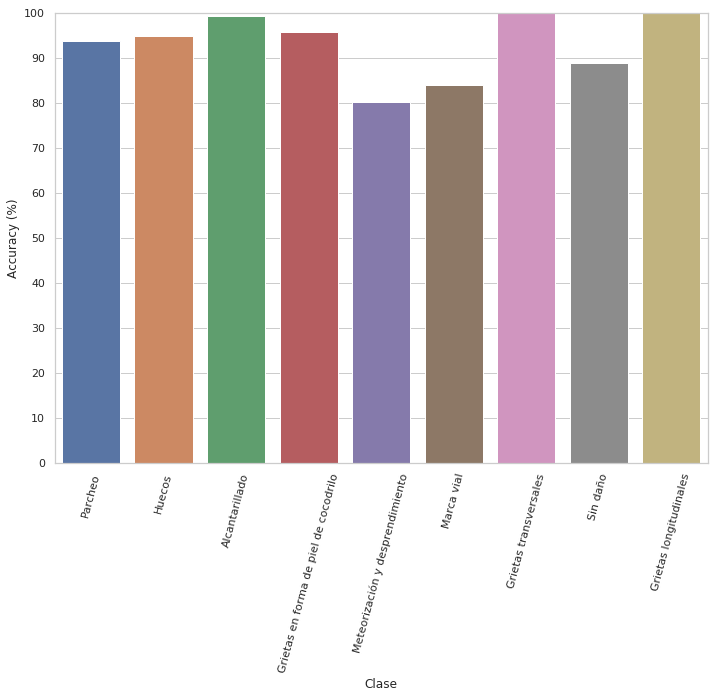

In [9]:
sns.set(style="whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(ax=ax, x=np.arange(len(LABELS2TARGETS)), y=accuracy_per_class)
plt.xticks(np.arange(len(LABELS2TARGETS)), list(LABELS2TARGETS.keys()))
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
plt.xlabel("Clase")
plt.ylabel("Accuracy (%)")

axes = plt.gca()
axes.set_ylim([0,100])
plt.yticks(np.arange(0,101, 10.0))

plt.savefig("accuracy_per_class.jpg", bbox_inches="tight")

In [10]:
nb_classes = 9

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs, classes = inputs.cuda(), classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 61.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 191.,   7.,   1.,   0.,   0.,   2.,   0.,   0.],
        [  1.,   0., 382.,   0.,   0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   6., 160.,   1.,   0.,   0.,   0.,   0.],
        [  1.,   3.,   2.,   5.,  69.,   1.,   4.,   0.,   1.],
        [  0.,   0.,  19.,   1.,   2., 141.,   5.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  41.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   1.,   0.,   0.,  24.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  52.]])


In [11]:
confusion_matrix.data.cpu().numpy() / np.array(class_total)

array([[0.93846154, 0.        , 0.01041667, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.95024876, 0.01822917, 0.00598802, 0.        ,
        0.        , 0.04878049, 0.        , 0.        ],
       [0.01538462, 0.        , 0.99479167, 0.        , 0.        ,
        0.        , 0.02439024, 0.        , 0.        ],
       [0.        , 0.        , 0.015625  , 0.95808383, 0.01162791,
        0.        , 0.        , 0.        , 0.        ],
       [0.01538462, 0.01492537, 0.00520833, 0.02994012, 0.80232558,
        0.00595238, 0.09756098, 0.        , 0.01923077],
       [0.        , 0.        , 0.04947917, 0.00598802, 0.02325581,
        0.83928571, 0.12195122, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01197605, 0.01162791,
        0.        , 0.        , 0.88888889, 0.        ],


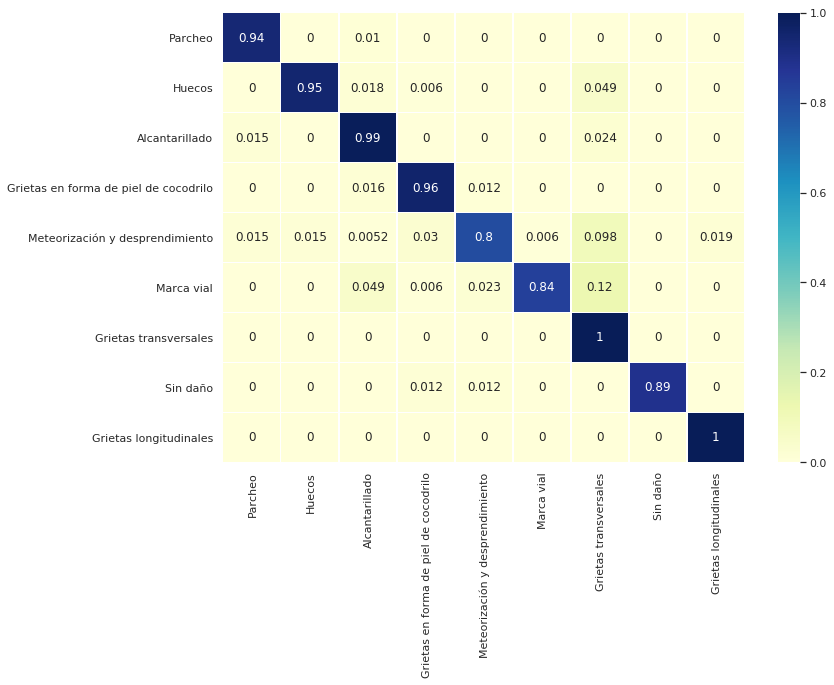

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
# Great cmaps -> YlGnBu / GnBu
ax = sns.heatmap(confusion_matrix.data.cpu().numpy() / np.array(class_total), cmap="YlGnBu", annot=True, linewidths=.5)
ax.set_yticklabels(ax.get_xticklabels(),rotation=0)
plt.yticks(np.arange(len(LABELS2TARGETS)), list(LABELS2TARGETS.keys()))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xticks(np.arange(len(LABELS2TARGETS)), list(LABELS2TARGETS.keys()))

trans = mtrans.Affine2D().translate(30, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

trans = mtrans.Affine2D().translate(0, -25)
for t in ax.get_yticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.savefig("confusion_matriix.jpg", bbox_inches="tight")